# Capstone Project
## Image classifier for the SVHN dataset
### Instructions

In this notebook, you will create a neural network that classifies real-world images digits. You will use concepts from throughout this course in building, training, testing, validating and saving your Tensorflow classifier model.

This project is peer-assessed. Within this notebook you will find instructions in each section for how to complete the project. Pay close attention to the instructions as the peer review will be carried out according to a grading rubric that checks key parts of the project instructions. Feel free to add extra cells into the notebook as required.

### How to submit

When you have completed the Capstone project notebook, you will submit a pdf of the notebook for peer review. First ensure that the notebook has been fully executed from beginning to end, and all of the cell outputs are visible. This is important, as the grading rubric depends on the reviewer being able to view the outputs of your notebook. Save the notebook as a pdf (File -> Download as -> PDF via LaTeX). You should then submit this pdf for review.

### Let's get started!

We'll start by running some imports, and loading the dataset. For this project you are free to make further imports throughout the notebook as you wish. 

In [1]:
import tensorflow as tf
from scipy.io import loadmat


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D

%matplotlib inline
import matplotlib.pyplot as plt

![SVHN overview image](data/svhn_examples.jpg)
For the capstone project, you will use the [SVHN dataset](http://ufldl.stanford.edu/housenumbers/). This is an  image dataset of over 600,000 digit images in all, and is a harder dataset than MNIST as the numbers appear in the context of natural scene images. SVHN is obtained from house numbers in Google Street View images. 

* Y. Netzer, T. Wang, A. Coates, A. Bissacco, B. Wu and A. Y. Ng. "Reading Digits in Natural Images with Unsupervised Feature Learning". NIPS Workshop on Deep Learning and Unsupervised Feature Learning, 2011.

Your goal is to develop an end-to-end workflow for building, training, validating, evaluating and saving a neural network that classifies a real-world image into one of ten classes.

In [2]:
# Run this cell to load the dataset

train = loadmat('data/train_32x32.mat')
test = loadmat('data/test_32x32.mat')

Both `train` and `test` are dictionaries with keys `X` and `y` for the input images and labels respectively.

## 1. Inspect and preprocess the dataset
* Extract the training and testing images and labels separately from the train and test dictionaries loaded for you.
* Select a random sample of images and corresponding labels from the dataset (at least 10), and display them in a figure.
* Convert the training and test images to grayscale by taking the average across all colour channels for each pixel. _Hint: retain the channel dimension, which will now have size 1._
* Select a random sample of the grayscale images and corresponding labels from the dataset (at least 10), and display them in a figure.

In [3]:
#Extract the training and testing images and labels separately from the train and test dictionaries loaded for you.

training_images = train['X']
testing_images = test['X']
training_labels = train['y']
testing_labels = test['y']

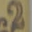

[2]


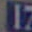

[1]


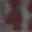

[4]


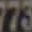

[7]


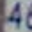

[4]


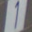

[1]


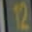

[1]


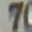

[7]


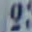

[2]


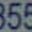

[5]


In [4]:
#Select a random sample of images and corresponding labels from the dataset (at least 10), and display them in a figure.
from PIL import Image
import random
import numpy as np

# amount of images to be shown
N = 10

def show_images(dataset, amount, convert_to="RGB"):   
    dataset_size = training_images.shape[-1]
    random_indexes = []
    for k in range(N):
        random_indexes.append(random.randrange(dataset_size))

    random_imgaes_labels = []
    for k in random_indexes:    
        img = Image.fromarray(dataset[..., k]).convert(convert_to)
        label = training_labels[k]
        random_imgaes_labels.append((img, label))

    for img, label in random_imgaes_labels:
        display(img)
        print(label)
        
show_images(training_images, N)

In [5]:
# Convert the training and test images to grayscale by taking the average across all colour channels for each pixel. 
# Hint: retain the channel dimension, which will now have size 1.
def convert_image_to_grayscale(imgs):
    new_dataset = np.empty((imgs.shape[-1], 32, 32))
    for k in range(imgs.shape[-1]):
        r = imgs[..., 0, k]
        g = imgs[..., 1, k]
        b = imgs[..., 2, k]
        
        gray_channel = np.mean( np.array([ r, g, b ]), axis=0 )
        gray_channel_int = gray_channel.astype(np.uint8)       
        new_dataset[k] = (gray_channel_int)
    
    return new_dataset

def show_gray_images(dataset, N, convert_to="RGB"):   
    dataset_size = training_images.shape[0]
    random_indexes = []
    for k in range(N):
        random_indexes.append(random.randrange(dataset_size))

    random_imgaes_labels = []
    for k in random_indexes:    
        img = Image.fromarray(dataset[k, ...]).convert(convert_to)
        label = training_labels[k]
        random_imgaes_labels.append((img, label))

    for img, label in random_imgaes_labels:
        display(img)
        print(label)

training_images_gray = convert_image_to_grayscale(training_images)
testing_images_gray = convert_image_to_grayscale(testing_images)

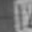

[1]


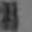

[3]


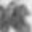

[6]


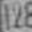

[2]


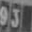

[3]


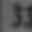

[3]


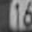

[1]


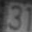

[3]


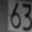

[6]


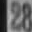

[2]


In [6]:
# Select a random sample of the grayscale images and corresponding labels from the dataset (at least 10), and display them in a figure.
show_gray_images(training_images_gray, 10, 'P')

## 2. MLP neural network classifier
* Build an MLP classifier model using the Sequential API. Your model should use only Flatten and Dense layers, with the final layer having a 10-way softmax output. 
* You should design and build the model yourself. Feel free to experiment with different MLP architectures. _Hint: to achieve a reasonable accuracy you won't need to use more than 4 or 5 layers._
* Print out the model summary (using the summary() method)
* Compile and train the model (we recommend a maximum of 30 epochs), making use of both training and validation sets during the training run. 
* Your model should track at least one appropriate metric, and use at least two callbacks during training, one of which should be a ModelCheckpoint callback.
* As a guide, you should aim to achieve a final categorical cross entropy training loss of less than 1.0 (the validation loss might be higher).
* Plot the learning curves for loss vs epoch and accuracy vs epoch for both training and validation sets.
* Compute and display the loss and accuracy of the trained model on the test set.

In [7]:
#Build an MLP classifier model using the Sequential API. Your model should use only Flatten and Dense layers, with the final layer having a 10-way softmax output.
#You should design and build the model yourself. Feel free to experiment with different MLP architectures. Hint: to achieve a reasonable accuracy you won't need to use more than 4 or 5 layers.
#Print out the model summary (using the summary() method)

def get_model(input_shape):
    weight_decay = 0.001
    model = Sequential([
        Dense(64, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(weight_decay), input_shape=input_shape),
        Dense(128, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(weight_decay)),
        Flatten(),
        Dense(128, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(weight_decay)),
        Dense(10, activation="softmax")
    ])
        
    return model

mlp_model = get_model(training_images_gray[0].shape)
print(mlp_model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32, 64)            2112      
_________________________________________________________________
dense_1 (Dense)              (None, 32, 128)           8320      
_________________________________________________________________
flatten (Flatten)            (None, 4096)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               524416    
_________________________________________________________________
dense_3 (Dense)              (None, 10)                1290      
Total params: 536,138
Trainable params: 536,138
Non-trainable params: 0
_________________________________________________________________
None


In [8]:
# Your model should track at least one appropriate metric, and use at least two callbacks during training, one of which should be a ModelCheckpoint callback.
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

def get_checkpoint_best():
    return ModelCheckpoint(filepath="checkpoints_best_only/checkpoint_{epoch:03d}", 
                           save_freq="epoch", save_weights_only=False, 
                           monitor="val_accuracy", save_best_only=True, verbose=1)

def get_early_stopping():
    return EarlyStopping(patience=3, monitor="val_accuracy")

checkpoint_best = get_checkpoint_best()
early_stopping = get_early_stopping()


In [9]:
# Compile and train the model (we recommend a maximum of 30 epochs), making use of both training and validation sets during the training run.
mlp_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
mlp_history = mlp_model.fit(x=training_images_gray, y=training_labels - 1, 
                        epochs=30, validation_split=0.15, batch_size=32, 
                        callbacks=[checkpoint_best, early_stopping])


Train on 62268 samples, validate on 10989 samples
Epoch 1/30
62240/62268 [============================>.] - ETA: 0s - loss: 3.0795 - accuracy: 0.3692
Epoch 00001: val_accuracy improved from -inf to 0.55610, saving model to checkpoints_best_only/checkpoint_001
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: checkpoints_best_only/checkpoint_001/assets
62268/62268 [==============================] - 135s 2ms/sample - loss: 3.0789 - accuracy: 0.3692 - val_loss: 1.5495 - val_accuracy: 0.5561
Epoch 2/30
62240/62268 [============================>.] - ETA: 0s - loss: 1.3795 - accuracy: 0.6183
Epoch 00002: val_accuracy improved from 0.55610 to 0.66275, saving model to checkpoints_best_only/checkpoint_002
INFO:tensorflow:Assets written to: checkpoints_best_only/checkpoint_002/assets
62268/62268 [==============================] - 117s 2ms/sample - loss: 1.3793 - accuracy: 0.6184 - val_loss: 1.2418 - val_accuracy: 0.6628
Epoch 3/30

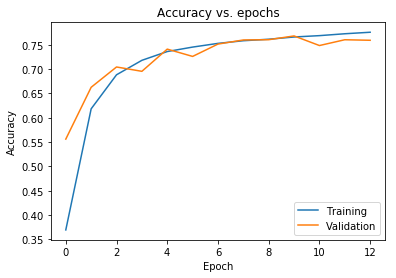

In [21]:
# Plot the learning curves for loss vs epoch and accuracy vs epoch for both training and validation sets.
plt.plot(mlp_history.history['accuracy'])
plt.plot(mlp_history.history['val_accuracy'])
plt.title('Accuracy vs. epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='lower right')
plt.show()

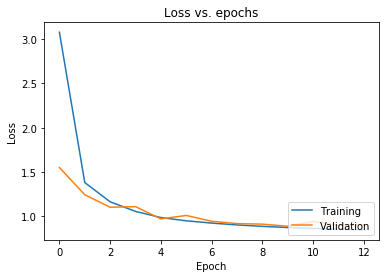

In [20]:
plt.plot(mlp_history.history['loss'])
plt.plot(mlp_history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='lower right')
plt.show()

In [12]:
# Compute and display the loss and accuracy of the trained model on the test set.
def get_test_accuracy(model, x_test, y_test):
    test_loss, test_acc = model.evaluate(x=x_test, y=y_test, verbose=2)
    print(f'accuracy: {test_acc:0.3f}, loss: {test_loss:0.3f}')

get_test_accuracy(mlp_model, testing_images_gray, testing_labels - 1)

26032/1 - 12s - loss: 1.0821 - accuracy: 0.7433
accuracy: 0.743, loss: 0.996


## 3. CNN neural network classifier
* Build a CNN classifier model using the Sequential API. Your model should use the Conv2D, MaxPool2D, BatchNormalization, Flatten, Dense and Dropout layers. The final layer should again have a 10-way softmax output. 
* You should design and build the model yourself. Feel free to experiment with different CNN architectures. _Hint: to achieve a reasonable accuracy you won't need to use more than 2 or 3 convolutional layers and 2 fully connected layers.)_
* The CNN model should use fewer trainable parameters than your MLP model.
* Compile and train the model (we recommend a maximum of 30 epochs), making use of both training and validation sets during the training run.
* Your model should track at least one appropriate metric, and use at least two callbacks during training, one of which should be a ModelCheckpoint callback.
* You should aim to beat the MLP model performance with fewer parameters!
* Plot the learning curves for loss vs epoch and accuracy vs epoch for both training and validation sets.
* Compute and display the loss and accuracy of the trained model on the test set.

In [13]:
#Build a CNN classifier model using the Sequential API. Your model should use the Conv2D, MaxPool2D, BatchNormalization, Flatten, Dense and Dropout layers. The final layer should again have a 10-way softmax output.
#You should design and build the model yourself. Feel free to experiment with different CNN architectures. Hint: to achieve a reasonable accuracy you won't need to use more than 2 or 3 convolutional layers and 2 fully connected layers.)
#The CNN model should use fewer trainable parameters than your MLP model.

def get_cnn_model(input_shape):
    model = Sequential([
        Conv2D(16, kernel_size=[4,4], padding="SAME", activation="relu", input_shape=input_shape),
        Conv2D(8, kernel_size=[4,4], padding="SAME", activation="relu", input_shape=input_shape),
        MaxPooling2D([8, 8]),
        Flatten(),
        Dense(64, activation="relu"),
        Dense(10, activation="softmax")
    ])
        
    return model

cnn_model = get_cnn_model((32, 32, 1))
print(cnn_model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 16)        272       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 8)         2056      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 4, 4, 8)           0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_5 (Dense)              (None, 10)                650       
Total params: 11,234
Trainable params: 11,234
Non-trainable params: 0
__________________________________________________

In [14]:
def get_cnn_checkpoint_best():
    return ModelCheckpoint(filepath="checkpoints_best_only/cnn_checkpoint_{epoch:03d}", 
                           save_freq="epoch", save_weights_only=False, 
                           monitor="val_accuracy", save_best_only=True, verbose=1)

cnn_checkpoint_best = get_cnn_checkpoint_best()
early_stopping = get_early_stopping()

In [15]:
# Compile and train the model (we recommend a maximum of 30 epochs), making use of both training and validation sets during the training run.
cnn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
cnn_history = cnn_model.fit(x=training_images_gray[..., np.newaxis], y=training_labels - 1, 
                        epochs=30, validation_split=0.15, batch_size=32, 
                        callbacks=[cnn_checkpoint_best, early_stopping])

Train on 62268 samples, validate on 10989 samples
Epoch 1/30
62240/62268 [============================>.] - ETA: 0s - loss: 1.7311 - accuracy: 0.4352
Epoch 00001: val_accuracy improved from -inf to 0.64173, saving model to checkpoints_best_only/cnn_checkpoint_001
INFO:tensorflow:Assets written to: checkpoints_best_only/cnn_checkpoint_001/assets
62268/62268 [==============================] - 566s 9ms/sample - loss: 1.7308 - accuracy: 0.4354 - val_loss: 1.1528 - val_accuracy: 0.6417
Epoch 2/30
62240/62268 [============================>.] - ETA: 0s - loss: 1.0282 - accuracy: 0.6834
Epoch 00002: val_accuracy improved from 0.64173 to 0.72327, saving model to checkpoints_best_only/cnn_checkpoint_002
INFO:tensorflow:Assets written to: checkpoints_best_only/cnn_checkpoint_002/assets
62268/62268 [==============================] - 565s 9ms/sample - loss: 1.0282 - accuracy: 0.6834 - val_loss: 0.9037 - val_accuracy: 0.7233
Epoch 3/30
62240/62268 [============================>.] - ETA: 0s - loss: 0

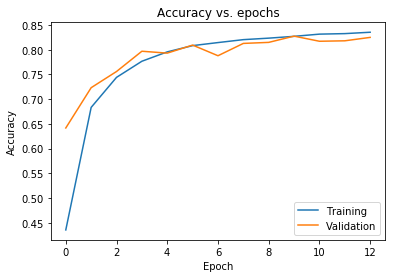

In [16]:
# Plot the learning curves for loss vs epoch and accuracy vs epoch for both training and validation sets.
plt.plot(cnn_history.history['accuracy'])
plt.plot(cnn_history.history['val_accuracy'])
plt.title('Accuracy vs. epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='lower right')
plt.show()

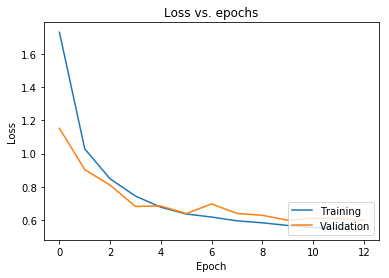

In [22]:
plt.plot(cnn_history.history['loss'])
plt.plot(cnn_history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='lower right')
plt.show()

In [23]:
# Compute and display the loss and accuracy of the trained model on the test set.
get_test_accuracy(cnn_model, testing_images_gray[..., np.newaxis], testing_labels - 1)

26032/1 - 55s - loss: 0.6731 - accuracy: 0.8036
accuracy: 0.804, loss: 0.669


## 4. Get model predictions
* Load the best weights for the MLP and CNN models that you saved during the training run.
* Randomly select 5 images and corresponding labels from the test set and display the images with their labels.
* Alongside the image and label, show each model’s predictive distribution as a bar chart, and the final model prediction given by the label with maximum probability.

In [67]:
from tensorflow.keras.models import load_model

prediction_amount = 5
random_idx = np.random.randint(testing_images_gray.shape[0], size=prediction_amount)

random_testing_images_gray = testing_images_gray[random_idx,:]
random_testing_labels = testing_labels[random_idx,:]

prediction_digits = list(range(1, 11))

In [68]:
mlp_r_module = load_model('checkpoints_best_only/checkpoint_010/')
mlp_r_predictions = mlp_r_module.predict(random_testing_images_gray)
print(mlp_r_predictions)

[[1.2801775e-04 2.9454615e-05 2.0065470e-07 7.1076214e-11 3.3918554e-12
  3.6639991e-10 9.9984086e-01 2.3711252e-07 4.5357451e-10 1.1625851e-06]
 [1.2701117e-02 8.8547207e-03 6.1079217e-03 1.5130135e-01 6.2701888e-03
  3.2671612e-02 1.2852144e-03 1.8805726e-01 4.2900586e-01 1.6374478e-01]
 [2.1827038e-01 5.6743715e-02 4.5061898e-03 2.1875731e-03 5.6031304e-03
  2.6694380e-04 6.7837405e-01 8.7603199e-05 1.7976271e-02 1.5984179e-02]
 [2.1887608e-02 8.4008789e-01 4.2205032e-02 6.7705527e-04 5.5804534e-04
  1.6454207e-04 6.5221772e-02 4.1845040e-03 2.1637604e-02 3.3757996e-03]
 [8.5985539e-03 5.8738806e-04 2.6439561e-03 6.6012694e-03 4.3919492e-03
  1.6823664e-01 1.4010836e-06 4.6579295e-01 4.3261621e-02 2.9988420e-01]]


In [69]:
cnn_r_module = load_model('checkpoints_best_only/cnn_checkpoint_010')
cnn_r_predictions = cnn_r_module.predict(random_testing_images_gray[..., np.newaxis])
print(cnn_r_predictions)

[[1.1941922e-04 1.4873418e-04 5.6326294e-06 3.9708559e-11 1.8574323e-11
  1.2335622e-12 9.9972624e-01 3.8091633e-10 1.1704611e-10 6.5497852e-10]
 [4.2336206e-03 4.8338771e-03 4.1440846e-03 3.6014184e-01 1.9239775e-05
  4.4356243e-04 9.4621455e-06 4.0729363e-03 5.1685691e-01 1.0524446e-01]
 [2.7399231e-03 1.5312321e-02 1.4037137e-04 9.6026963e-07 8.8455451e-08
  3.0563960e-08 9.8173964e-01 2.4647175e-06 1.7377345e-06 6.2461513e-05]
 [4.3329529e-02 4.6593666e-01 3.8613215e-01 4.2705189e-02 3.3374815e-03
  1.4040793e-03 1.1473086e-02 1.1785192e-02 2.8087318e-02 5.8093248e-03]
 [1.2399153e-02 6.0797529e-04 2.6156694e-01 1.2826516e-03 1.5569750e-03
  1.5262867e-03 4.4690087e-03 6.8938804e-01 9.1977408e-03 1.8005256e-02]]


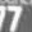

Real label: [7]
Predicted by MLP label=7
Predicted by CNN label=7


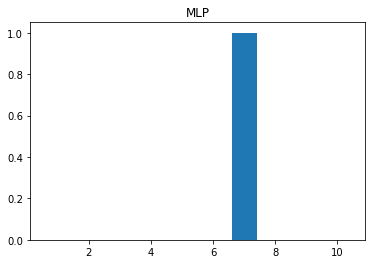

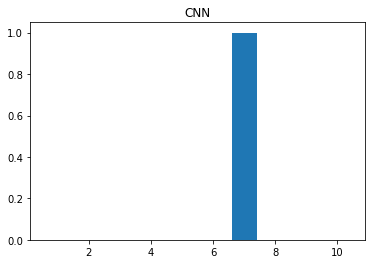

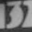

Real label: [3]
Predicted by MLP label=9
Predicted by CNN label=9


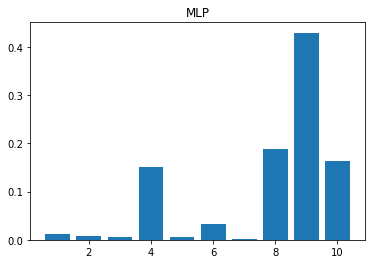

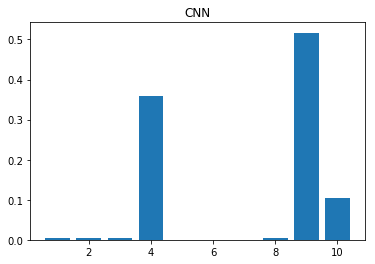

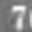

Real label: [7]
Predicted by MLP label=7
Predicted by CNN label=7


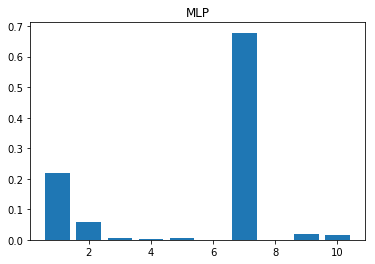

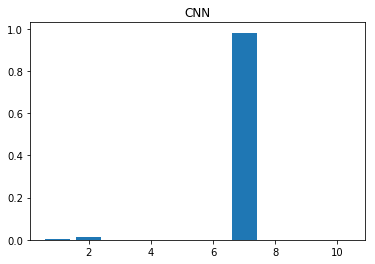

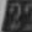

Real label: [2]
Predicted by MLP label=2
Predicted by CNN label=2


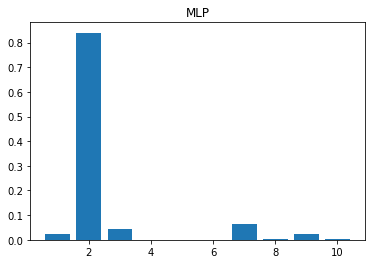

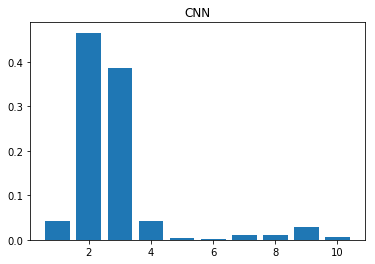

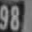

Real label: [8]
Predicted by MLP label=8
Predicted by CNN label=8


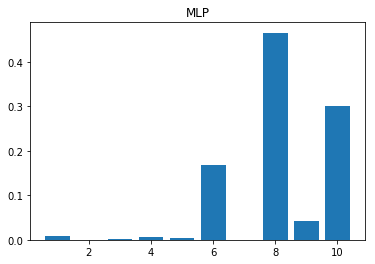

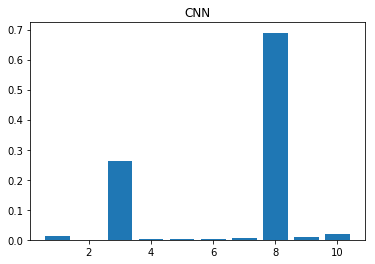

In [70]:
for i in range(prediction_amount):
    img = Image.fromarray(random_testing_images_gray[i, ...]).convert("L")
    label = random_testing_labels[i]
    display(img)
    print(f"Real label: {label}")
    print(f"Predicted by MLP label={prediction_digits[np.argmax(mlp_r_predictions[i])]}")
    print(f"Predicted by CNN label={prediction_digits[np.argmax(cnn_r_predictions[i])]}")
    
    plt.title("MLP")
    plt.bar(prediction_digits, mlp_r_predictions[i])
    plt.show()
    
    plt.title("CNN")
    plt.bar(prediction_digits, cnn_r_predictions[i])
    plt.show()